# Predicting transport cost of shipments 

In [1]:
# Import general libraries
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Import modeling libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Data Acquisition 

In [2]:
# Read raw data
data = pd.read_csv('train_data.csv', delimiter=';')
data = data.reset_index()
data['SID'] = 'S' + data['index'].astype('str').str.zfill(7)
data = data.drop(columns=['index'])
print('A SID Shipment ID column was created')
print('Training data set has the following shape: ', data.shape)
data.head(2)

A SID Shipment ID column was created
Training data set has the following shape:  (251155, 10)


,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost,SID
0,27.22,105.59,26.91,108.67,0.513,0.195,True,2017-04-24,0.247,S0000000
1,25.00,109.79,25.34,108.59,0.484,0.195,True,2017-07-27,0.248,S0000001


In [3]:
# Check for original column data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251155 entries, 0 to 251154
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   origin_latitude        251155 non-null  float64
 1   origin_longitude       251155 non-null  float64
 2   destination_latitude   251155 non-null  float64
 3   destination_longitude  251155 non-null  float64
 4   weight                 251155 non-null  float64
 5   loading_meters         251155 non-null  float64
 6   is_adr                 251155 non-null  bool   
 7   shipping_date          251155 non-null  object 
 8   cost                   251155 non-null  float64
 9   SID                    251155 non-null  object 
dtypes: bool(1), float64(7), object(2)
memory usage: 17.5+ MB


In [4]:
# Basic statistics for relevant numerical columns
data[['weight', 'loading_meters', 'cost']].describe()

,weight,loading_meters,cost
count,251155.000000,251155.000000,251155.000000
mean,0.405943,0.167496,0.343925
std,0.127647,0.063195,0.129915
min,0.050000,0.000000,0.017000
25%,0.328000,0.195000,0.249000
50%,0.475000,0.195000,0.333000
75%,0.490000,0.195000,0.415000
max,1.000000,0.995000,2.349000


In [5]:
# Create a categorical column for cost, only for further exploration steps
data['CostCat'] = 'Note Categorized'
data.loc[data['cost'] <= 0.25, 'CostCat'] = 'Low'
data.loc[(data['cost'] > 0.25) & (data['cost'] <= 0.5), 'CostCat'] = 'Medium'
data.loc[(data['cost'] > 0.5) & (data['cost'] <= 1) , 'CostCat'] = 'High'
data.loc[data['cost'] > 1, 'CostCat'] = 'Expensive'
data['CostCat'].value_counts()

Medium       161716
Low           63846
High          25425
Expensive       168
Name: CostCat, dtype: int64

## EDA & Categorization 

### Geo Locations 

In [6]:
# Create a df with all location points, their frequency and a unique id
columns = ['latitude', 'longitude', 'F']

origins = data.groupby(['origin_latitude', 'origin_longitude'])['SID'].count().reset_index()
origins.columns = columns
destinations = data.groupby(['destination_latitude', 'destination_longitude'])['SID'].count().reset_index()
destinations.columns = columns

locations = pd.concat([origins, destinations]).groupby(['latitude', 'longitude'])['F'].sum().reset_index()
locations = locations.sort_values(by='F', ascending=False)
locations = locations.reset_index()
locations['LID'] = 'L' + locations['index'].astype('str').str.zfill(5)
locations = locations.drop(columns=['index'])

locations.head(2)

,latitude,longitude,F,LID
0,26.91,108.67,18624,L03708
1,25.76,109.61,17364,L02617


In [7]:
# Visualize locations
map_world = folium.Map(location=[25, 108], zoom_start= 6)

for lat, lng in zip(locations['latitude'], locations['longitude']):
    folium.CircleMarker([lat, lng], radius=1, color='blue', fill=True, fill_color='blue', parse_html=False).add_to(map_world)

map_world

In [8]:
# Calculate distance between origins and destinations
def my_euclidean(row):
    a = row['origin_latitude'] 
    b = row['origin_longitude'] 
    x = row['destination_latitude'] 
    y = row['destination_longitude']
    d = math.sqrt((a-x)**2 + (b-y)**2)
    return d

data['distance'] = data.apply(my_euclidean, axis=1)
data.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost,SID,CostCat,distance
0,27.22,105.59,26.91,108.67,0.513,0.195,True,2017-04-24,0.247,S0000000,Low,3.095561
1,25.00,109.79,25.34,108.59,0.484,0.195,True,2017-07-27,0.248,S0000001,Low,1.247237


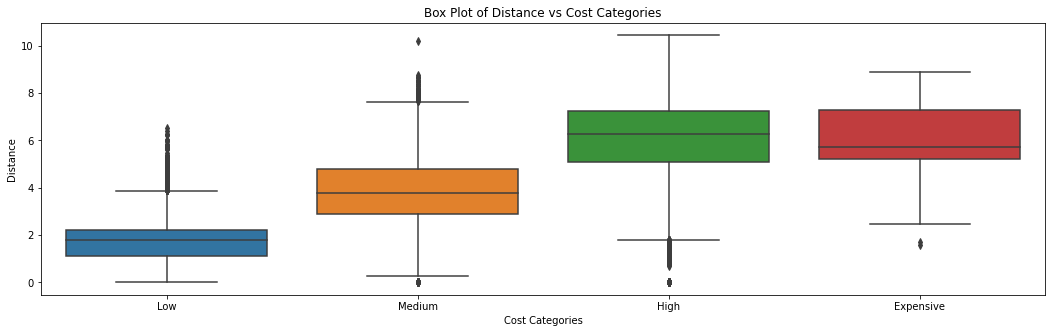

In [9]:
# Does distance affects cost?
fig, ax = plt.subplots(figsize=(18,5))
sns.boxplot(data=data, x= 'CostCat', y='distance')
plt.title('Box Plot of Distance vs Cost Categories')
plt.xlabel('Cost Categories')
plt.ylabel('Distance')
plt.show()

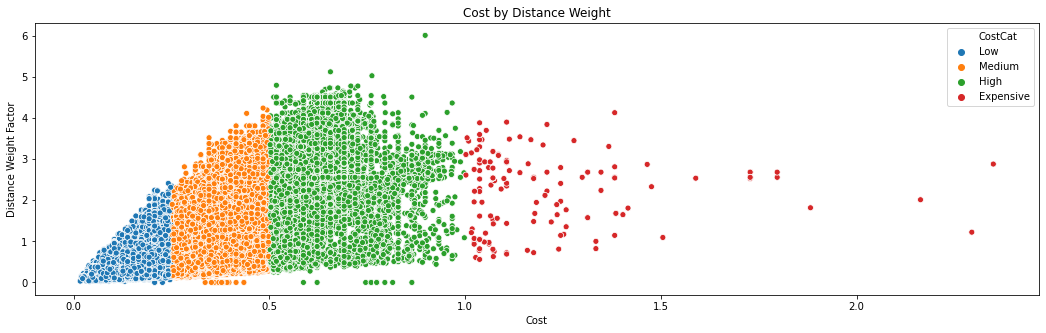

In [10]:
# What about a distance-weight factor?
data['dw'] = data['distance'] * data['weight']
fig, ax = plt.subplots(figsize=(18,5))
sns.scatterplot(data=data, x='cost', y='dw', hue='CostCat')
plt.title('Cost by Distance Weight')
plt.xlabel('Cost')
plt.ylabel('Distance Weight Factor')
plt.show()

### Weight 

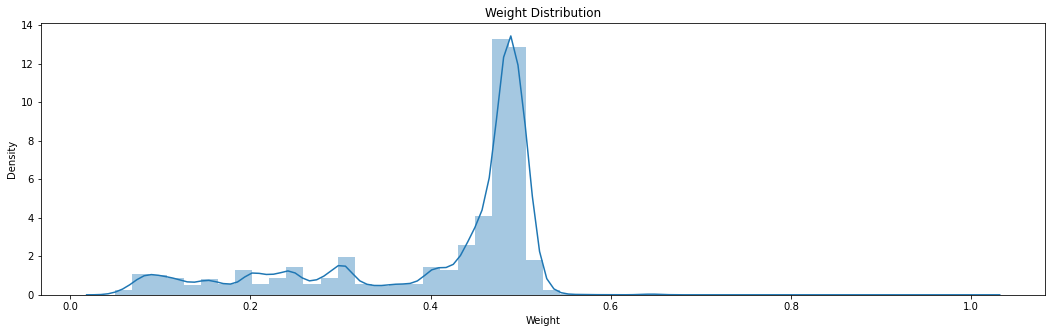

In [11]:
# Distribution
fig, ax = plt.subplots(figsize=(18,5))
sns.distplot(data['weight'])
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.show()

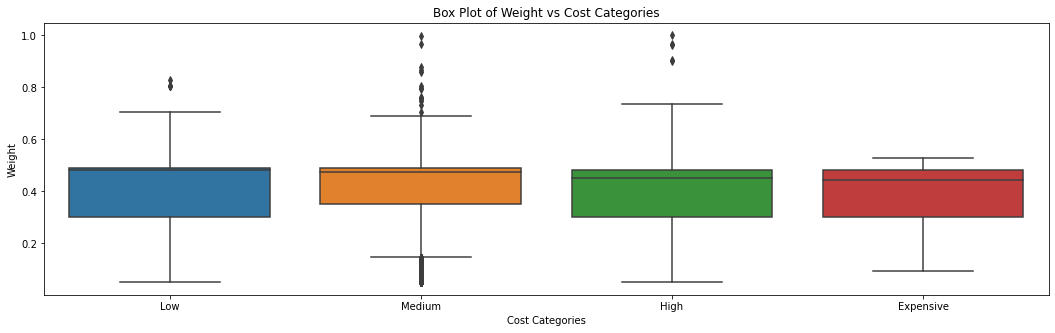

In [12]:
# Boxplot exploration
fig, ax = plt.subplots(figsize=(18,5))
sns.boxplot(data=data, x= 'CostCat', y='weight')
plt.title('Box Plot of Weight vs Cost Categories')
plt.xlabel('Cost Categories')
plt.ylabel('Weight')
plt.show()

### Loading Meters 

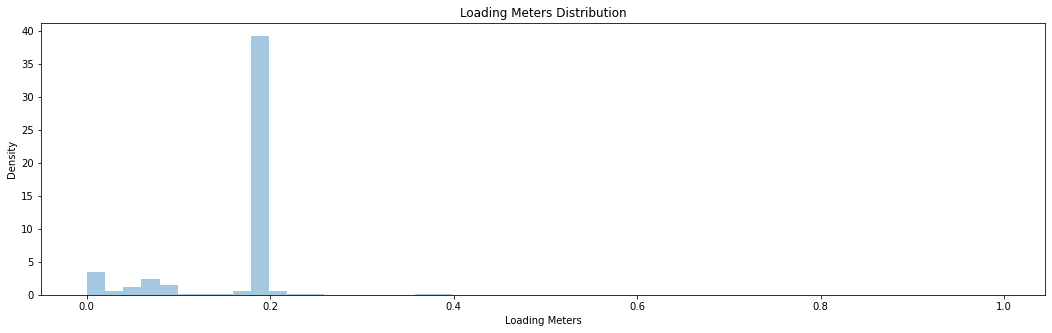

In [13]:
# Distribution
fig, ax = plt.subplots(figsize=(18,5))
sns.distplot(data['loading_meters'])
plt.title('Loading Meters Distribution')
plt.xlabel('Loading Meters')
plt.ylabel('Density')
plt.show()

In [14]:
# Creating additional column for standard values: 0.195 as a base
def my_lm_category(row):
    lm = row['loading_meters']
    if lm == 0.0: return 'Missing'
    elif lm < 0.195: return 'Partial'
    elif lm == 0.195: return '1P'
    elif lm < 0.389: return '1PPlus'
    elif lm == 0.389: return '2P'
    elif lm > 0.389: return '2PPlus'
    else: return 'Other'

data['lm_type'] = data.apply(my_lm_category, axis=1)
data['lm_type'].value_counts()

1P         191700
Partial     37076
Missing     17209
1PPlus       4525
2P            565
2PPlus         80
Name: lm_type, dtype: int64

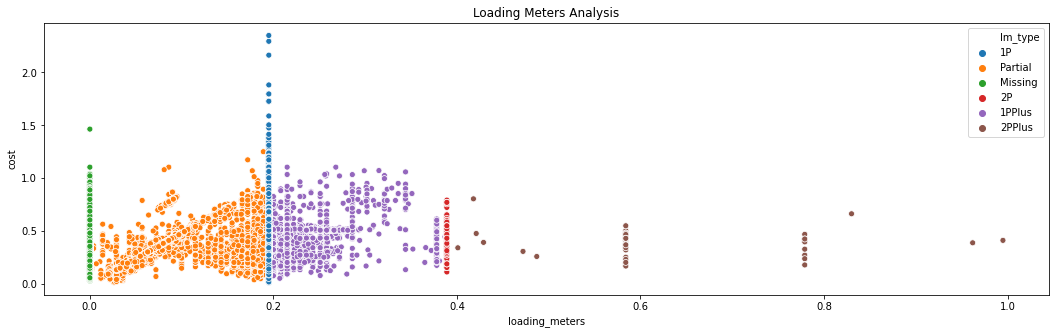

In [15]:
# Scatter plot for loading meters
fig, ax = plt.subplots(figsize=(18,5))
sns.scatterplot(data=data, x='loading_meters', y='cost', hue='lm_type')
plt.title('Loading Meters Analysis')
plt.show()

### Dangerous Goods 

In [16]:
print('Dangerous Goods column has {} null values'.format(data['is_adr'].isnull().sum()))
data['is_adr'].value_counts()

Dangerous Goods column has 0 null values


True    251155
Name: is_adr, dtype: int64

Dangerous goods always has a true value, which is useless. Dangerous goods column will simply be deleted because it adds no value.

In [17]:
# Drop dangerous goods column
data = data.drop(columns=['is_adr'])

### Shipping Date 

In [18]:
# What is the time period?
print('Time period starts: ', data['shipping_date'].min())
print('Time period ends  : ', data['shipping_date'].max())

Time period starts:  2017-01-01
Time period ends  :  2019-01-31


In [19]:
# Extract additional columns from the date
data['shipping_date'] = pd.to_datetime(data['shipping_date'], format='%Y/%m/%d')
data['year'] = pd.DatetimeIndex(data['shipping_date']).year
data['month'] = pd.DatetimeIndex(data['shipping_date']).month
data['week'] = pd.DatetimeIndex(data['shipping_date']).week
data['day'] = pd.DatetimeIndex(data['shipping_date']).weekday
data['wd'] = pd.DatetimeIndex(data['shipping_date']).weekday <= 4
data.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,shipping_date,cost,SID,CostCat,distance,dw,lm_type,year,month,week,day,wd
0,27.22,105.59,26.91,108.67,0.513,0.195,2017-04-24,0.247,S0000000,Low,3.095561,1.588023,1P,2017,4,17,0,True
1,25.00,109.79,25.34,108.59,0.484,0.195,2017-07-27,0.248,S0000001,Low,1.247237,0.603663,1P,2017,7,30,3,True


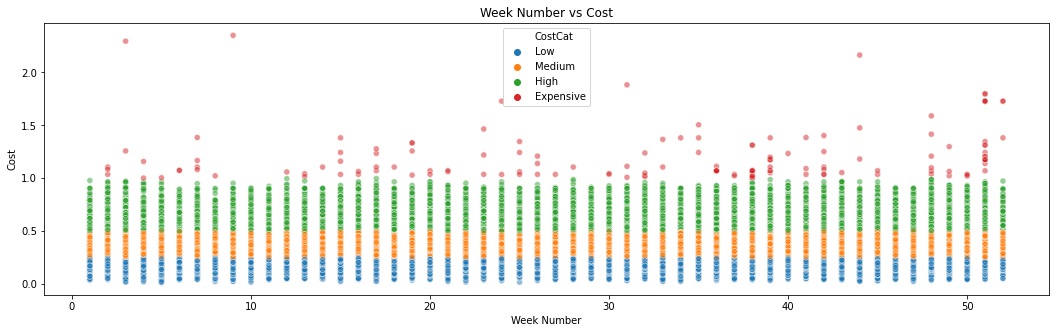

In [20]:
# Is the cost affected by the week number? Are shipments more expensive on Christmas than in summer?
fig, ax = plt.subplots(figsize=(18,5))
sns.scatterplot(data=data, x='week', y='cost', hue='CostCat', alpha=0.5)
plt.title('Week Number vs Cost')
plt.xlabel('Week Number')
plt.ylabel('Cost')
plt.show()

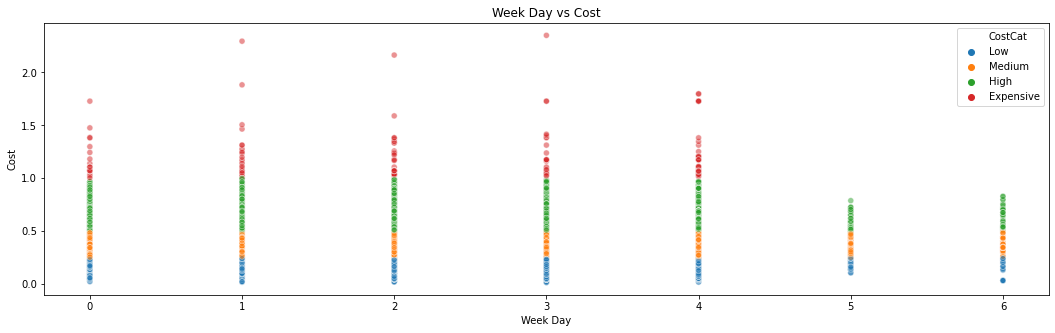

In [21]:
# Are shipments more expensive on weekends than on regular week working days?
fig, ax = plt.subplots(figsize=(18,5))
sns.scatterplot(data=data, x='day', y='cost', hue='CostCat', alpha=0.5)
plt.title('Week Day vs Cost')
plt.xlabel('Week Day')
plt.ylabel('Cost')
plt.show()

### Cost (Target Feature) 

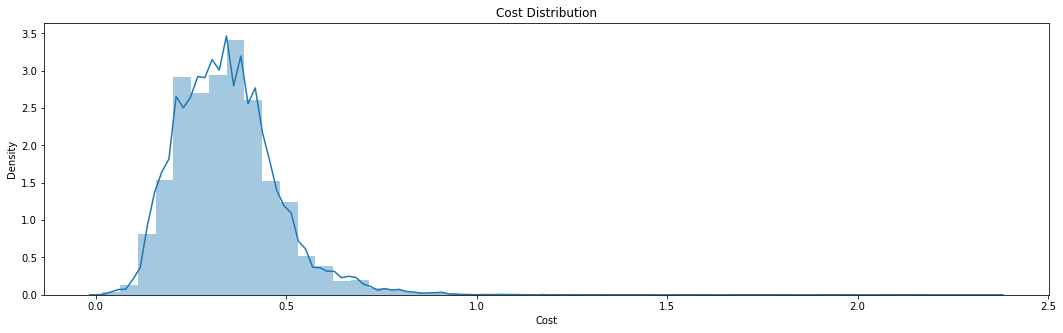

In [22]:
# Distribution
fig, ax = plt.subplots(figsize=(18,5))
sns.distplot(data['cost'])
plt.title('Cost Distribution')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

In [23]:
# Cost by category (artificially created)
data['CostCat'].value_counts(normalize=True)

Medium       0.643889
Low          0.254210
High         0.101232
Expensive    0.000669
Name: CostCat, dtype: float64

## Data Pre Processing 

In [24]:
# Select only some of the columns to be used for modeling
data_preprocessed = data[['SID', 'distance', 'weight', 'loading_meters', 'lm_type', 'year', 'month','cost']]
data_preprocessed.head(2)

,SID,distance,weight,loading_meters,lm_type,year,month,cost
0,S0000000,3.095561,0.513,0.195,1P,2017,4,0.247
1,S0000001,1.247237,0.484,0.195,1P,2017,7,0.248


In [25]:
# Create interaction columns for distance and weight
data_preprocessed['dw'] = data_preprocessed['distance'] * data_preprocessed['weight']
data_preprocessed['dww'] = data_preprocessed['distance'] * data_preprocessed['weight'] * data_preprocessed['weight']
data_preprocessed.head(2)

,SID,distance,weight,loading_meters,lm_type,year,month,cost,dw,dww
0,S0000000,3.095561,0.513,0.195,1P,2017,4,0.247,1.588023,0.814656
1,S0000001,1.247237,0.484,0.195,1P,2017,7,0.248,0.603663,0.292173
2,S0000002,2.438463,0.484,0.195,1P,2017,2,0.276,1.180216,0.571225
3,S0000003,3.758324,0.504,0.195,1P,2017,4,0.276,1.894195,0.954674
4,S0000004,7.713585,0.484,0.195,1P,2018,11,0.553,3.733375,1.806954


## Modeling 

In [29]:
# Encoding categorical columns
enc = OneHotEncoder()
enccolumns = ['year', 'month', 'lm_type']
e = np.asarray(data_preprocessed[enccolumns])
enc.fit_transform(e, y=None)
encoded = pd.DataFrame(enc.fit_transform(e, y=None).toarray())
encoded.columns = enc.get_feature_names(['y', 'm', 'lm'])

features = pd.concat([data_preprocessed, encoded], axis=1)
features = features.drop(columns=['SID', 'year', 'month', 'cost', 'lm_type'])
features.head(2)

,distance,weight,loading_meters,dw,dww,y_2017,y_2018,y_2019,m_1,m_2,...,m_9,m_10,m_11,m_12,lm_1P,lm_1PPlus,lm_2P,lm_2PPlus,lm_Missing,lm_Partial
0,3.095561,0.513,0.195,1.588023,0.814656,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.247237,0.484,0.195,0.603663,0.292173,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Train Test Split
X = np.asarray(features)
y = np.asarray(data_preprocessed['cost'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
kfolds = 3
print('Training Rows          : ', len(X_train))
print('Test Rows              : ', len(X_test))
print('Folds to be used in CV : ', kfolds)

Training Rows          :  175808
Test Rows              :  75347
Folds to be used in CV :  3


### Linear Regression 

In [32]:
param_grid = {'fit_intercept': [True, False]}
lm = GridSearchCV(LinearRegression(), param_grid, cv=kfolds)
lm.fit(X_train, y_train)

print('Simple Linear Regression Trainning')
print('Best Parameters :', lm.best_params_)
print('Best Score      :', lm.best_score_)

Simple Linear Regression Trainning
Best Parameters : {'fit_intercept': True}
Best Score      : 0.6490064292943319


### Ridge Regression 

In [33]:
param_grid = {'alpha': [0, 0.01, 0.1, 0.5],
              'normalize': [True, False]}
rr = GridSearchCV(Ridge(), param_grid, cv=kfolds)
rr.fit(X_train, y_train)

print('Ridge Regression Trainning')
print('Best Parameters :', rr.best_params_)
print('Best Score      :', rr.best_score_)

Ridge Regression Trainning
Best Parameters : {'alpha': 0.1, 'normalize': False}
Best Score      : 0.6490066015202943


### Lasso Regression 

In [34]:
param_grid = {'alpha': [0, 0.01, 0.1, 0.5],
              'normalize': [True, False]}
lr = GridSearchCV(Lasso(), param_grid, cv=kfolds)
lr.fit(X_train, y_train)

print('Lasso Regression Trainning')
print('Best Parameters :', lr.best_params_)
print('Best Score      :', lr.best_score_)

Ridge Regression Trainning
Best Parameters : {'alpha': 0, 'normalize': True}
Best Score      : 0.6490064293225833


### Decision Tree Regression 

In [35]:
dt = DecisionTreeRegressor()
dt_cv = cross_validate(dt, X_train, y_train, cv=kfolds)
dt.fit(X_train, y_train)

print('Decision Tree Trainning')
print('Mean Score      :', dt_cv['test_score'].mean())

Decision Tree Trainning
Mean Score      : 0.6522686622021787


### Random Forest Regression 

In [36]:
rf = RandomForestRegressor(criterion='mse', n_estimators=150) #how deep?
rf_cv = cross_validate(rf, X_train, y_train, cv=kfolds)
rf.fit(X_train, y_train)

print('Random Forest Trainning')
print('Score      :', rf_cv['test_score'].mean())

Random Forest Trainning
Score      : 0.7892850931419835


## Results 

In [37]:
# Make predictions on test data
lm_yhat = lm.predict(X_test)
rr_yhat = rr.predict(X_test)
lr_yhat = lr.predict(X_test)
dt_yhat = dt.predict(X_test)
rf_yhat = rf.predict(X_test)
print('Prediction Length: ', len(lm_yhat))

Prediction Length:  75347


In [38]:
# Gather predictions on training data
df = pd.DataFrame(y_test)
df['lm_yhat'] = lm_yhat
df['rr_yhat'] = rr_yhat
df['lr_yhat'] = lr_yhat
df['dt_yhat'] = dt_yhat
df['rf_yhat'] = rf_yhat

df.describe()

,0,lm_yhat,rr_yhat,lr_yhat,dt_yhat,rf_yhat
count,75347.000000,75347.000000,75347.000000,75347.000000,75347.000000,75347.000000
mean,0.344205,0.343785,0.343785,0.343785,0.343950,0.343757
std,0.130354,0.104257,0.104256,0.104258,0.127507,0.118398
min,0.017000,0.114971,0.114944,0.114948,0.017000,0.033640
25%,0.249000,0.263142,0.263137,0.263138,0.249000,0.255645
50%,0.333000,0.334942,0.334944,0.334944,0.335000,0.334277
75%,0.415000,0.414972,0.414945,0.414971,0.415000,0.417272
max,2.349000,0.770756,0.770646,0.770739,1.403000,1.141284


In [39]:
# Score models
lm_score = r2_score(y_test, lm_yhat)
rr_score = r2_score(y_test, rr_yhat)
lr_score = r2_score(y_test, lr_yhat)
dt_score = r2_score(y_test, dt_yhat)
rf_score = r2_score(y_test, rf_yhat)

print('Score on Test Data')
print('Linear Model Score     :  ', lm_score)
print('Ridge Regression Score :  ', rr_score)
print('Lasso Regression Score :  ', lr_score)
print('Decision Tree Score    :  ', dt_score)
print('Random Forest Score    :  ', rf_score)
print('Random Forest will be used as Model!')

Score on Test Data
Linear Model Score     :   0.6441981106507657
Ridge Regression Score :   0.6441991402109852
Lasso Regression Score :   0.6441983495419472
Decision Tree Score    :   0.6655888972571704
Random Forest Score    :   0.7897186994389106
Random Forest will be used as Model!
